Detect through the whole ROIs, apply sliding window detection, to find objects/boxes

In [1]:
import os
from os.path import isfile
from timer import *
from dataset_operations import detect_on_roi
import glob
import torchvision
import torch

In [2]:
parent_dir = "rois2/"
img_dir = parent_dir + "images/"
false_pos_dir = parent_dir + "tiles/false_positives/"
false_pos_label_dir = false_pos_dir + "labels/"
false_pos_image_dir = false_pos_dir + "images/"

false_neg_dir = parent_dir + "tiles/false_negatives/"
false_neg_label_dir = false_neg_dir + "labels/"
false_neg_image_dir = false_neg_dir + "images/"

os.makedirs(false_pos_dir, exist_ok=True)
os.makedirs(false_pos_label_dir, exist_ok=True)
os.makedirs(false_pos_image_dir, exist_ok=True)

os.makedirs(false_neg_dir, exist_ok=True)
os.makedirs(false_neg_label_dir, exist_ok=True)
os.makedirs(false_neg_image_dir, exist_ok=True)



In [3]:
false_negative = True
false_positive = True

roi_list_fp = img_dir + 'train_rois.txt'

In [4]:
def delete_last_label(dir):
    # Getting the list of files/directories 
    # in the specified path Filtering the  
    # list to exclude the directory names 
    target_labels = list(filter(os.path.isfile, glob.glob(dir + "\*")))
    # Sorting file list based on the  
    # creation time of the files 
    target_labels.sort(key=os.path.getctime) 
    # print(false_pos_labels)
    if len(target_labels) > 0:
        os.remove(target_labels[-1])
    # for file in os.listdir(false_pos_label_dir):
    #     os.remove(os.path.join(false_pos_label_dir, file))

def clean_dir(dir):
    for file in os.listdir(dir):
        os.remove(os.path.join(dir, file))

# delete_last_label(false_pos_label_dir)
# delete_last_label(false_neg_label_dir)

clean_dir(false_pos_label_dir)
clean_dir(false_neg_label_dir)

roi_paths = []
if isfile(roi_list_fp):
    with open(roi_list_fp, 'r') as f:
        lines = f.readlines()
        for line in lines:
            roi_paths.append(line.strip())

print(len(roi_paths))

334


In [5]:
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes=2).to('cuda')
model.load_state_dict(torch.load('rois2/models/round1/2024_09_16/round1_model_epoch10.pth'))

<All keys matched successfully>

In [6]:
tot_cnt = 0
correct_cnt = 0
timer = Timer()

for i, roi_fp in enumerate(roi_paths):
    timer.start()
    print('roi: ', i + 1, '/', len(roi_paths), '  ', roi_fp.split('/')[-1])
    
    roi_tot_cnt = 0
    roi_correct_cnt = 0
    true_positives, total, false_pos_pred_num = detect_on_roi(model= model, roi_fp=roi_fp, window_size = 512, stride=256, nms_thr=0.1, 
                                                         intersect_thr=0.5, score_thr=0.1, 
                                                         false_negative=false_negative, false_positive=false_positive, 
                                                         false_neg_label_dir=false_neg_label_dir, false_pos_label_dir=false_pos_label_dir,)
    
    timer.stop()
    roi_tot_cnt += total
    roi_correct_cnt += true_positives
    if total > 0:
        print('     correct / total = ', roi_correct_cnt, '/', roi_tot_cnt, ' = ', true_positives/total, 'time: ', timer.elapsed_time())
    else:
        print('     no ground truth labels, time: ', timer.elapsed_time())
    
    tot_cnt += roi_tot_cnt
    correct_cnt += roi_correct_cnt

    print('     num of total false positive preds: ', false_pos_pred_num)
    
    
print('recall = ', correct_cnt/tot_cnt)

roi:  1 / 334    expert1_id-6381471f7f8a5e686a52765f_left-36214_top-41262_right-39265_bottom-46232.png
     Time to process current roi:  0 hours, 0 minutes, 5.66 seconds
     correct / total =  57 / 79  =  0.7215189873417721 time:  0 hours, 0 minutes, 5.69 seconds
     num of total false positive preds:  11575
roi:  2 / 334    expert1_id-6381471f7f8a5e686a52765f_left-36627_top-47431_right-39464_bottom-52356.png
     Time to process current roi:  0 hours, 0 minutes, 5.93 seconds
     correct / total =  47 / 69  =  0.6811594202898551 time:  0 hours, 0 minutes, 5.96 seconds
     num of total false positive preds:  14505
roi:  3 / 334    expert1_id-6381471f7f8a5e686a527706_left-75035_top-24698_right-80405_bottom-28610.png
     Time to process current roi:  0 hours, 0 minutes, 8.73 seconds
     correct / total =  22 / 34  =  0.6470588235294118 time:  0 hours, 0 minutes, 8.78 seconds
     num of total false positive preds:  18121
roi:  4 / 334    expert1_id-6381471f7f8a5e686a5277c2_left-680

rois2/tiles/false_positives/labels/


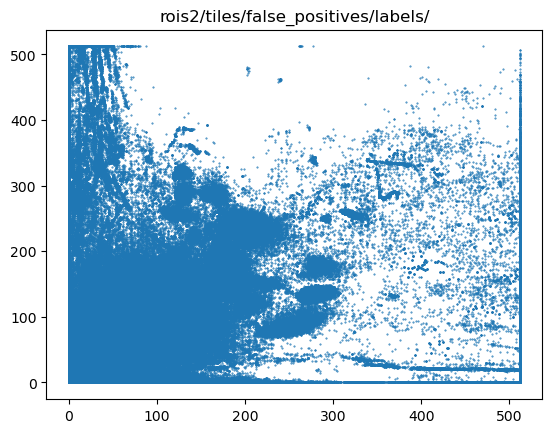

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [512, 512, 512, 512, 512, 512, 512, 512, 512, 512]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [512, 512, 512, 512, 512, 512, 512, 512, 512, 512]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [253440, 253440, 254464, 255488, 255488, 256000, 256512, 257024, 259072, 259584]


In [7]:
import matplotlib.pyplot as plt 

label_dir = false_pos_label_dir
print(label_dir)

W = []
H = []
area = []
ratio = []
for root, dirs, files in os.walk(label_dir):
    for file in files:
        if file.lower().endswith(('.txt')):
            label_path = os.path.join(root, file)
            with open(label_path) as file:
                lines = file.readlines()
                for line in lines:
                    temp = line.split(' ')
                    x1,y1,x2,y2 = float(temp[1]), float(temp[2]), float(temp[3]), float(temp[4])
            
                    W.append(int(x2)-int(x1))
                    H.append(int(y2)-int(y1))
                    area.append((int(x2)-int(x1))*(int(y2)-int(y1)))
                    # ratio.append((int(x2)-int(x1))/(int(y2)-int(y1)))
            # print(f'Image: {file}, Width: {width}, Height: {height}')
plt.title(label_dir)
plt.scatter(W,H,s=0.2)
plt.show()

W.sort()  
H.sort()
area.sort()    
print(W[0:10], W[-10:])
print(H[0:10], H[-10:])
print(area[0:10], area[-10:])

In [8]:
import numpy as np
print(np.mean(area))

4978.670809780668


In [9]:
print(len(W), len(H), len(area))

6496080 6496080 6496080
